In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
# tqdm is a progress bar library
import os

In [2]:

# using the SQLite Table to read data.
con = sqlite3.connect('amazon-fine-food-reviews/database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [8]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [9]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{"mightn't", 'other', 'until', 'they', 'having', 'herself', 'against', 'down', 'had', 'in', 'why', 'was', 'wasn', 'any', 'some', 'above', "you're", 'of', 'or', 'me', 'where', 'should', 'd', 'we', 'is', 'its', "couldn't", 'doesn', 'but', 'between', 'i', 'to', 'from', 'own', "you'd", 'are', 'do', "hasn't", 'so', 'because', 'up', 'shouldn', 'this', 'most', 'isn', 'very', "don't", 'more', "isn't", 'won', 'just', 'be', 'when', "weren't", 'you', 'whom', 'by', 'only', 'shan', 'then', 'did', "she's", 'ours', 'at', 'the', 'been', 'into', 'needn', 'once', 'as', 'yours', "that'll", 'each', 'same', 'and', 'haven', 'themselves', "wasn't", 'them', 'if', 'here', 'yourselves', 'y', 'under', 'what', 'your', 'after', "doesn't", 'there', 'were', 'wouldn', 'these', 'not', "won't", 'those', 'below', "should've", 'theirs', 'such', 'yourself', 'both', 'weren', 'will', "mustn't", 've', 'mustn', 's', 'no', 'again', 'ourselves', 'about', 'hadn', 'his', 't', 'aren', "aren't", 'didn', 'on', "shouldn't", 'that', '

In [10]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    for i, sent in enumerate(tqdm(final['Text'].values)):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")
        final_string.append(str1)

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

In [19]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

print(type(final))

<class 'pandas.core.frame.DataFrame'>


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
import warnings
warnings.filterwarnings("ignore")

####BOW

In [21]:
# [7.2.2] Bag of Words (BoW)

labels = final.head(50000)['Score']

X_1, X_test, y_1, y_test = cross_validation.train_test_split(final.head(50000),labels, test_size=0.3, random_state=0)
#BoW
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())

print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (35000, 24078)
the number of unique words  24078


In [24]:
X_tr = count_vect.transform(X_tr['CleanedText'].values)
X_cv = count_vect.transform(X_cv['CleanedText'].values)
X_test =count_vect.transform(X_test['CleanedText'].values)

In [27]:
X_1 = count_vect.transform(X_1['CleanedText'].values)

<h1>Applying KNN brute force on BOW</h1>

In [22]:
fc = final_counts.toarray()
#labels = final.head(5000)['Score']
type(fc)

numpy.ndarray

In [ ]:
#X_1, X_test, y_1, y_test = cross_validation.train_test_split(fc,labels, test_size=0.3, random_state=0)


In [25]:
#X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
#X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

for i in range(1,20,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i , n_jobs =4 , algorithm='brute')

    # fitting the model on crossvalidation train
    knn.fit(X_tr, y_tr)

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc))
    



CV accuracy for k = 1 is 82%

CV accuracy for k = 3 is 84%

CV accuracy for k = 5 is 85%

CV accuracy for k = 7 is 85%

CV accuracy for k = 9 is 85%

CV accuracy for k = 11 is 85%

CV accuracy for k = 13 is 85%

CV accuracy for k = 15 is 85%

CV accuracy for k = 17 is 84%

CV accuracy for k = 19 is 84%


In [ ]:
#X_1, X_test, y_1, y_test = cross_validation.train_test_split(fc,labels, test_size=0.3, random_state=0)

# creating odd list of K for KNN
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k , n_jobs =4 ,algorithm='brute')
    scores = cross_val_score(knn, X_1, y_1, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [28]:
knn = KNeighborsClassifier(n_neighbors=9 , n_jobs =4 ,algorithm='brute')

    # fitting the model on crossvalidation train
knn.fit(X_1, y_1)
 


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=4, n_neighbors=9, p=2,
           weights='uniform')

In [29]:
pred = knn.predict(X_test)

y_final = np.array(y_test)

import numpy as np
from sklearn.metrics import accuracy_score

print(accuracy_score(y_final,pred))

knn.score(X_test,y_test)

#accuray for BOW using KNN with n = 9 .

0.8509333333333333


0.8509333333333333

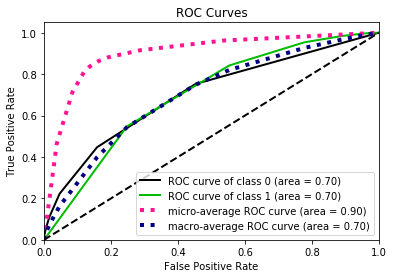

In [30]:

import matplotlib.pyplot as plt
import scikitplot as skplt
predicted_probas = knn.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, predicted_probas)

plt.show()

[[  116  2177]
 [   59 12648]]


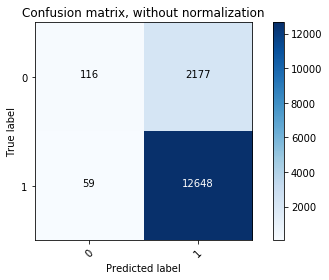

In [32]:
from sklearn.metrics import confusion_matrix
import itertools
# import some data to play with
#iris = datasets.load_iris()
#X = iris.data
#y = iris.target
class_names = ['0','1']

# Split the data into a training set and a test set
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results

y_pred = knn.predict(X_test)
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
 
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')



plt.show()

In [ ]:
dm = final_counts.todense()

labels = final.head(1000)['Score']

In [ ]:
X_1, X_test, y_1, y_test = cross_validation.train_test_split(dm,labels, test_size=0.3, random_state=0)

In [ ]:
#X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i , n_jobs =4 , algorithm='kd_tree')

    # fitting the model on crossvalidation train
    knn.fit(X_tr, y_tr)

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc))
    
knn = KNeighborsClassifier(n_neighbors=15 , n_jobs =4 , algorithm='auto')
knn.fit(X_tr,y_tr)
pred = knn.predict(X_test)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 15 is %d%%' % (acc))

In [ ]:
X_1, X_test, y_1, y_test = cross_validation.train_test_split(dm,labels, test_size=0.3, random_state=0)

# creating odd list of K for KNN
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k , n_jobs =4 ,algorithm='kd_tree')
    scores = cross_val_score(knn, X_1, y_1, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [ ]:
knn = KNeighborsClassifier(n_neighbors=9 , n_jobs =4 ,algorithm='kd_tree')

# fitting the model on crossvalidation train
knn.fit(X_1, y_1)
pred = knn.predict(X_test)

y_final = np.array(y_test)


print(accuracy_score(y_final,pred))

knn.score(X_test,y_test)

#accuray for BOW using KNN with n = 9 .

## [7.2.4] Bi-Grams and n-Grams.

**Motivation**

Now that we have our list of words describing positive and negative reviews lets analyse them.<br>

We begin analysis by getting the frequency distribution of the words as shown below

In [ ]:
with open('positive_words.pkl', 'rb') as f:
    all_positive_words = pickle.load(f)
with open('negitive_words.pkl', 'rb') as f:
    all_negative_words = pickle.load(f)
    
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

<b>Observation:-</b> From the above it can be seen that the most common positive and the negative words overlap for eg. 'like' could be used as 'not like' etc. <br>
So, it is a good idea to consider pairs of consequent words (bi-grams) or q sequnce of n consecutive words (n-grams)

In [ ]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

# [7.2.5] TF-IDF

In [ ]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final.head(1000)['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

In [ ]:
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[100000:100010])

In [ ]:
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,25)

In [ ]:
#top_tfidf

In [ ]:
# TSNE for TF-IDF

fc = final_tf_idf.toarray()

labels = final.head(1000)['Score']
#print(labels)


In [ ]:
X_1, X_test, y_1, y_test = cross_validation.train_test_split(fc,labels, test_size=0.3, random_state=0)


In [ ]:
#X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i , n_jobs =4 , algorithm='brute')

    # fitting the model on crossvalidation train
    knn.fit(X_tr, y_tr)

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc))
    
knn = KNeighborsClassifier(n_neighbors=15 , n_jobs =4 , algorithm='auto')
knn.fit(X_tr,y_tr)
pred = knn.predict(X_test)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 15 is %d%%' % (acc))

In [ ]:
X_1, X_test, y_1, y_test = cross_validation.train_test_split(fc,labels, test_size=0.3, random_state=0)

# creating odd list of K for KNN
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k , n_jobs =4 , algorithm='brute')
    scores = cross_val_score(knn, X_1, y_1, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [ ]:
knn = KNeighborsClassifier(n_neighbors=7 , n_jobs =4 ,algorithm='brute')

    # fitting the model on crossvalidation train
knn.fit(X_1, y_1)
 

In [ ]:
pred = knn.predict(X_test)

y_final = np.array(y_test)


print(accuracy_score(y_final,pred))

knn.score(X_test,y_test)

#accuray for TF-IDF using KNN with n = 7 .

In [ ]:
from sklearn.metrics import f1_score

print(f1_score(y_final,pred))

In [ ]:
dm = final_counts.todense()

labels = final.head(1000)['Score']
X_1, X_test, y_1, y_test = cross_validation.train_test_split(dm,labels, test_size=0.3, random_state=0)

In [ ]:
#X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i , n_jobs =4 , algorithm='kd_tree')

    # fitting the model on crossvalidation train
    knn.fit(X_tr, y_tr)

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc))
    
knn = KNeighborsClassifier(n_neighbors=15 , n_jobs =4 , algorithm='auto')
knn.fit(X_tr,y_tr)
pred = knn.predict(X_test)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 15 is %d%%' % (acc))

In [ ]:
X_1, X_test, y_1, y_test = cross_validation.train_test_split(dm,labels, test_size=0.3, random_state=0)

# creating odd list of K for KNN
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k , n_jobs =4 ,algorithm='kd_tree')
    scores = cross_val_score(knn, X_1, y_1, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [ ]:
knn = KNeighborsClassifier(n_neighbors=9 , n_jobs =4 ,algorithm='kd_tree')

# fitting the model on crossvalidation train
knn.fit(X_1, y_1)
pred = knn.predict(X_test)

y_final = np.array(y_test)


print(accuracy_score(y_final,pred))

knn.score(X_test,y_test)

#accuray for BOW using KNN with n = 9 .

In [ ]:

print(f1_score(y_final,pred))

# [7.2.6] Word2Vec

In [ ]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need
is_your_ram_gt_16g=False
want_to_read_sub_set_of_google_w2v = True
want_to_read_whole_google_w2v = True
if not is_your_ram_gt_16g:
    if want_to_read_sub_set_of_google_w2v and  os.path.isfile('google_w2v_for_amazon.pkl'):
        with open('google_w2v_for_amazon.pkl', 'rb') as f:
            # model is dict object, you can directly access any word vector using model[word]
            model = pickle.load(f)
else:
    if want_to_read_whole_google_w2v and os.path.isfile('GoogleNews-vectors-negative300.bin'):
        model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

# print("the vector representation of word 'computer'",model.wv['computer'])
# print("the similarity between the words 'woman' and 'man'",model.wv.similarity('woman', 'man'))
# print("the most similar words to the word 'woman'",model.wv.most_similar('woman'))
# this will raise an error
# model.wv.most_similar('tasti')  # "tasti" is the stemmed word for tasty, tastful

In [ ]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())

In [ ]:
print(final['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

In [ ]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [ ]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

In [ ]:
#w2v_model.wv.most_similar('tasti')
print(w2v_model.wv)

In [ ]:
w2v_model.wv.most_similar('like')

# [7.2.7] Avg W2V, TFIDF-W2V

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent[:10000]): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

In [ ]:

sv=  np.array(sent_vectors)
sv_dm = sv.tode
#sv = sv[:4000]
labels = final.head(10000)['Score']
#print(labels)
sv.shape

In [ ]:


X_1, X_test, y_1, y_test = cross_validation.train_test_split(sv,labels, test_size=0.3, random_state=0)

#X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i , n_jobs =4 , algorithm='brute')

    # fitting the model on crossvalidation train
    knn.fit(X_tr, y_tr)

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc))
    
knn = KNeighborsClassifier(n_neighbors=15 , n_jobs =4 , algorithm='auto')
knn.fit(X_tr,y_tr)
pred = knn.predict(X_test)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 15 is %d%%' % (acc))

In [ ]:
knn = KNeighborsClassifier(n_neighbors=7 , n_jobs =4 ,algorithm='brute')

    # fitting the model on crossvalidation train
knn.fit(X_1, y_1)

In [ ]:
pred = knn.predict(X_test)

y_final = np.array(y_test)

import numpy as np
from sklearn.metrics import accuracy_score

print(accuracy_score(y_final,pred))

knn.score(X_test,y_test)

#accuray for Avg-W2V using KNN with n = 7 .

In [ ]:

sv=  np.array(sent_vectors)
#sv = sv[:4000]
labels = final.head(10000)['Score']
#print(labels)
sv.shape

In [ ]:


X_1, X_test, y_1, y_test = cross_validation.train_test_split(sv,labels, test_size=0.3, random_state=0)

#X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i , n_jobs =4 , algorithm='kd_tree')

    # fitting the model on crossvalidation train
    knn.fit(X_tr, y_tr)

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc))
    
knn = KNeighborsClassifier(n_neighbors=15 , n_jobs =4 , algorithm='auto')
knn.fit(X_tr,y_tr)
pred = knn.predict(X_test)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 15 is %d%%' % (acc))

In [ ]:
knn = KNeighborsClassifier(n_neighbors=7 , n_jobs =4 ,algorithm='kd_tree')

# fitting the model on crossvalidation train
knn.fit(X_1, y_1)

In [ ]:
pred = knn.predict(X_test)

y_final = np.array(y_test)

import numpy as np
from sklearn.metrics import accuracy_score

print(accuracy_score(y_final,pred))

knn.score(X_test,y_test)

#accuray for Avg-W2V using KNN with n = 7 .

In [ ]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final.head(10000)['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent[:10000]): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [ ]:
tdfsv = np.array(tfidf_sent_vectors)
labels = final.head(10000)['Score']

In [ ]:


#print(labels)
X_1, X_test, y_1, y_test = cross_validation.train_test_split(tdfsv,labels, test_size=0.3, random_state=0)

#X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i , n_jobs =4 , algorithm='brute')

    # fitting the model on crossvalidation train
    knn.fit(X_tr, y_tr)

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc))
    
knn = KNeighborsClassifier(n_neighbors=15 , n_jobs =4 , algorithm='auto')
knn.fit(X_tr,y_tr)
pred = knn.predict(X_test)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 15 is %d%%' % (acc))

In [ ]:
knn = KNeighborsClassifier(n_neighbors=11 , n_jobs =4,algorithm='brute' )

    # fitting the model on crossvalidation train
knn.fit(X_1, y_1)

In [ ]:
pred = knn.predict(X_test)

y_final = np.array(y_test)

import numpy as np
from sklearn.metrics import accuracy_score

print(accuracy_score(y_final,pred))

knn.score(X_test,y_test)

#accuray for TF-IDF-W2V using KNN with n = 11 .

In [ ]:
X_1, X_test, y_1, y_test = cross_validation.train_test_split(tdfsv,labels, test_size=0.3, random_state=0)

#X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i , n_jobs =4 , algorithm='kd_tree')

    # fitting the model on crossvalidation train
    knn.fit(X_tr, y_tr)

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc))
    
knn = KNeighborsClassifier(n_neighbors=15 , n_jobs =4 , algorithm='auto')
knn.fit(X_tr,y_tr)
pred = knn.predict(X_test)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 15 is %d%%' % (acc))

In [ ]:
knn = KNeighborsClassifier(n_neighbors=11 , n_jobs =4,algorithm='kd_tree' )

    # fitting the model on crossvalidation train
knn.fit(X_1, y_1)

In [ ]:
pred = knn.predict(X_test)

y_final = np.array(y_test)

import numpy as np
from sklearn.metrics import accuracy_score

print(accuracy_score(y_final,pred))

knn.score(X_test,y_test)

#accuray for TF-IDF-W2V using KNN with n = 11 .

In [ ]:
print(f1_score(y_final,pred))

In [1]:
from sklearn.metrics import confusion_matrix
y_true = [2, 0, 2, 2, 0, 1]
y_pred = [0, 0, 2, 2, 0, 2]
confusion_matrix(y_true, y_pred)




array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])